# Using pyplume with uniform ambient conditions


This example demonstrates how to use **pyplume** to calculate a solution to the plume equations in a uniform ambient stratification. To validate the model we'll also calculate an analytical solution using the equations presented in [Slater et al. (2016)](https://doi.org/10.1175/JPO-D-15-0132.1) and compare the results.

First of all, do some generic imports and set matplotlib as inline since we're in a jupyter notebook.

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

And some more specific imports. We'll use the **gsw** package to make it easy to calculate water properties like density using the latest TEOS-10 standard. And of course we need **pyplume** too. In this case we also pull in *const* which contains the constants which **pyplume** uses so we can use the same ones in the analytical solution.

In [2]:
import gsw

# This is necessary in binder 
# Or if pyplume isn't in your pythonpath and you launched the notebook from the examples directory
import sys
sys.path.append('..')
import pyplume, const

# If pyplume is a package in your python path, you should use this line instead:
#from pyplume import pyplume, const

## Model setup

In theory, you *should* be able to experiment with changing any values in the Model Setup section without breaking the model. Try it and let me know if/how you manage to break it!

First set the discharge at the inlet ($Q_0$) in m$^3$s$^{-1}$, here we'll use 10 m$^3$s$^{-1}$.

In [3]:
q_0 = 10.

Now set the water depth in metres, let's take a big glacier in Greenland with a 700 metre deep terminus.

In [4]:
h_w = 700.

We want a uniform ambient temperature and salinity, set the values here and we'll create the actual profile below.

In [5]:
t_a = 3.
s_a = 33.

*pyplume.calc_plume()* has default initial conditions for temperature and salinity, but let's explicitly define them here to ensure the analytical solution is consistent.

In [6]:
t_0 = 1.0e-3
s_0 = 1.0e-3

## Initialise a uniform ambient temperature and salinity profile

First we make a pressure array which is a little longer than the depth, to be on the safe side.

In [7]:
pressure = np.arange(0, h_w + 10., 1.)

Then we use the ambient temperature and salinity properties (which were set above) to create synthetic profiles of temperature and salinity in a **pyplume** *Ambient* object called *ambient*.

In [8]:
ambient = pyplume.Ambient(h_w, np.ones(pressure.shape) * s_a,
                               np.ones(pressure.shape) * t_a,
                               pressure)

## Set up the initial conditions for the models

*pyplume.calc_plume()* requires the velocity ($u_0$) and radius ($b_0$) at the inlet. 

These can usually be calculated in **pyplume** using *b_0, u_0 = pyplume.inlet(h_i, h_w, q)* but the analytical solution used here assumes $\Gamma_0=1$, so to be consistent we'll calculate them using the same assumption.

First of all, we need the pressure at the inlet ($p_0$). Our *ambient* object has a handy *get_pres_z()* method to get this easily. $z$ is the height above the source, so at the inlet this should be 0.

In [9]:
p_0 = ambient.get_pres_z(0)

Then we need the density of the plume at the inlet ($\rho_{p0}$), which we can get with *gsw.rho()* and our initial temperature and salinity, which we defined above.

In [10]:
rho_p_0 = gsw.rho(s_0, t_0, p_0)

And we can get the ambient density at the inlet ($\rho_{a0}$) with another handy *ambient* method: *get_rho_z()*.

In [11]:
rho_a_0 = ambient.get_rho_z(0)

Now we need the reduced gravity ($g'_0$) at the inlet, so we use the following equation

\begin{equation}
g'_0 = -g \frac{\rho_{p0} - \rho_{a0}}{\rho_{ref}},
\end{equation}

where $g$ is 9.81 m/s (set in *pyplume.const*) and $\rho_{ref}$ is a reference density which we also take from *pyplume.const*.

In [12]:
g_dash_0 = -const.G * (rho_p_0 - rho_a_0) / const.RHO_REF

Then we use the following equations to get the radius and velocity of the inlet:

\begin{equation}
b_0 = \left( \frac{32 \alpha \Gamma_0 Q^2_0}{5 \pi^2 g'_0} \right) ^{1/5} 
~\mathrm{and}~
u_0 = \frac{2}{\pi} \left( \frac{5 \pi^2 g'_0}{32 \alpha \Gamma_0} \right) ^{2/5} Q^{1/5}_0,
\end{equation}

where, as stated above, we assume $\Gamma_0 = 1$ and $\alpha$ is the entrainment coefficient which we take from *pyplume.const*. 

In [13]:
gamma_0 = 1.

b_0 = ((32. * const.E_0 * gamma_0 * q_0**2.) / (5 * math.pi**2. * g_dash_0))**(1./5.)

u_0 = (2./math.pi) * ((5 * math.pi**2. * g_dash_0) / (32. * const.E_0 * gamma_0))**(2./5.) * q_0**(1./5.)

## Calculate steady state plume solution

Now we're ready and we can use *pyplume.calc_plume()* to solve the plume equations numerically.

In [14]:
num_soln = pyplume.calc_plume(u_0, b_0, h_w, ambient, 
                              t_0 = t_0, s_0 = s_0, MELT = False)

*pyplume.calc_plume()* returns a dict, let's see what's in there:

In [15]:
print(num_soln.keys())

['s_p', 'z', 't_a', 's_a', 'u_p', 'b_p', 't_p', 'm_p']


We can check the definition of these in the *pyplume.calc_plume* docstring:

In [16]:
print(pyplume.calc_plume.__doc__)

Solve the plume equations for the specified initial conditions


    Args:
        u_0 (float) :               velocity at the source (m/s)
        b_0 (float) :               radius at the source (m)
        h_w (float) :               total water column depth (m)
        ambient (Ambient object) :  containing temperature and salinity profiles
        t_0 (float, optional) :     temperature at the plume source (deg C, default=1.0e-3)
        s_0 (float, optional) :     salinity at the plume source (kg/m3, default=1.0e-3)
        MELT (boolean, optional) :  whether to include the melt feedback (default=True)

    Returns:
        plume (dict) : dictionary containing:
                            'z'     height above source (m)
                            'b_p'   plume radius (m)
                            'u_p'   vertical velocity (m/s)
                            't_p'   temperature (deg C)
                            's_p'   salinity (kg/m3)
                            'm_p'   melt r

# Analytical solution

Now, let's calculate an analytical solution for the same initial conditions to check everything went well with the integration of the numerical solution.

First, initialise a dict for the results.

In [17]:
ana_soln = {}

Then get the same z-coords which were used for the numerical solution.

In [18]:
ana_soln['z'] = num_soln['z'].copy()

Calculate the virtual inlet height, which is an adjustment made to account for the inlet not being an ideal point source, using the following relation:

\begin{equation}
z_0 = \frac{5}{6\alpha} \left( \frac{32\alpha Q^2_0}{5 \pi^2 g'_0} \right) ^{1/5}.
\end{equation}

In [19]:
z_virt = (5. / (6. * const.E_0)) * ((32. * const.E_0 * q_0**2.) / (5 * math.pi**2. * g_dash_0))**(1./5.)

The following equations provide the analytical solution which we can use to calculate profiles of the radius (*b*), velocity (*u*), temperature (*T*) and salinity (*S*) within the plume:

\begin{equation}
b = \frac{6}{5} \alpha (z + z_0),
~~
u = \frac{5}{6\alpha} \left( \frac{9 \alpha Q_0 g'_0}{5\pi} \right) ^{1/3} (z + z_0)^{-1/3},
\end{equation}

\begin{equation}
T = T_0 + (T_a - T_0) \left[ 1- \left( \frac{z_0}{z+z_0} \right) ^{5/3} \right],
~~\mathrm{and}~~
S = S_a \left[ 1- \left( \frac{z_0}{z+z_0} \right) ^{5/3} \right].
\end{equation}

In [20]:
ana_soln['b_p'] = (6./5.) * const.E_0 * (ana_soln['z'] + z_virt)

ana_soln['u_p'] = (5./ (6. * const.E_0)) * ((9. * const.E_0 * q_0 * g_dash_0) / (5. * math.pi))**(1./3.) * (ana_soln['z'] + z_virt)**(-1./3.)

ana_soln['t_p'] = t_0 + (t_a - t_0) * (1 - (z_virt / (ana_soln['z'] + z_virt))**(5./3.))

ana_soln['s_p'] = s_a * (1 - (z_virt / (ana_soln['z'] + z_virt))**(5./3.))

# Results

Now we have the results of both models, we can plot a comparison between the numerical and analytical solutions.

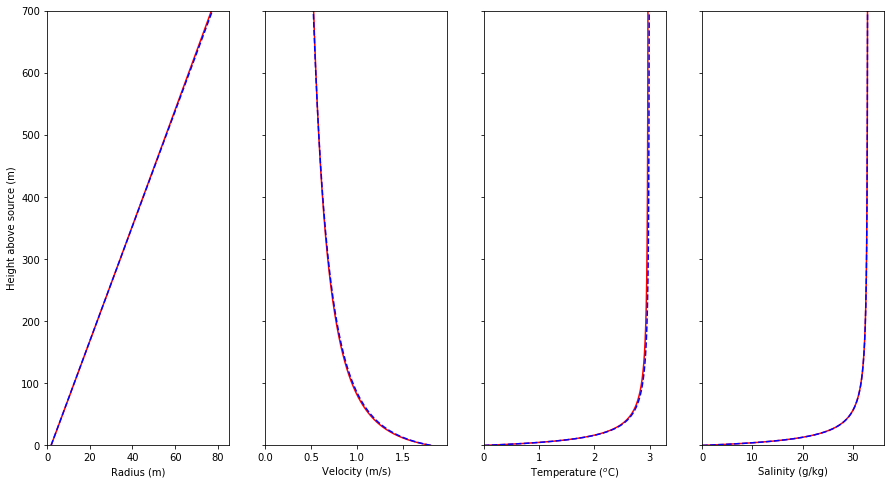

In [21]:
f,ax = plt.subplots(1,4, sharey=True, figsize=(15,8))

# radius
ax[0].plot(num_soln['b_p'], num_soln['z'], 'r-')
ax[0].plot(ana_soln['b_p'], ana_soln['z'], 'b--')
ax[0].set_xlim(0, np.nanmax([num_soln['b_p'], ana_soln['b_p']])*1.1)
ax[0].set_ylim(0,h_w)
ax[0].set_xlabel('Radius (m)')
ax[0].set_ylabel('Height above source (m)')

# velocity
ax[1].plot(num_soln['u_p'], num_soln['z'], 'r-')
ax[1].plot(ana_soln['u_p'], ana_soln['z'], 'b--')
ax[1].set_xlim(0, np.nanmax([num_soln['u_p'], ana_soln['u_p']])*1.1)
ax[1].set_xlabel('Velocity (m/s)')

# temperature
ax[2].plot(num_soln['t_p'], num_soln['z'], 'r-')
ax[2].plot(ana_soln['t_p'], ana_soln['z'], 'b--')
ax[2].set_xlim(0, np.nanmax([num_soln['t_p'], ana_soln['t_p']])*1.1)
ax[2].set_xlabel('Temperature ($^o$C)')

# salinity
ax[3].plot(num_soln['s_p'], num_soln['z'], 'r-')
ax[3].plot(ana_soln['s_p'], ana_soln['z'], 'b--')
ax[3].set_xlim(0, np.nanmax([num_soln['s_p'], ana_soln['s_p']])*1.1)
ax[3].set_xlabel('Salinity (g/kg)')

Looks pretty good, we can also do some quick stats to see how well our numerical solution is doing compared to the analytical one.

In [22]:
def rmse(a, b):
    return np.sqrt(((a - b) ** 2).mean())

print("Radius RMSE: {:.2f} (m)".format(rmse(num_soln['b_p'], ana_soln['b_p'])))
print("Velocity RMSE: {:.2f} (m/s)".format(rmse(num_soln['u_p'], ana_soln['u_p'])))
print(u"Temperature RMSE: {:.2f} (\N{DEGREE SIGN}C)".format(rmse(num_soln['t_p'], ana_soln['t_p'])))
print("Salinity RMSE: {:.2f} (g/kg)".format(rmse(num_soln['s_p'], ana_soln['s_p'])))

Radius RMSE: 0.18 (m)
Velocity RMSE: 0.01 (m/s)
Temperature RMSE: 0.02 (°C)
Salinity RMSE: 0.01 (g/kg)
